In [1]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi, SNLE, MNLE, SNRE, SNRE_A
from sbi.utils.posterior_ensemble import NeuralPosteriorEnsemble
import numpy as np
import moments
from matplotlib import pyplot as plt
from sbi.utils import BoxUniform
from sbi.utils import MultipleIndependent
from sbi.neural_nets.embedding_nets import PermutationInvariantEmbedding, FCEmbedding
from sbi.utils.user_input_checks import process_prior, process_simulator
from sbi.utils import get_density_thresholder, RestrictedPrior


/home/rahul/PopGen/SimulationSFS/SFS/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/rahul/PopGen/SimulationSFS/SFS/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
import seaborn as sns

# Setup devices and constants
the_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_size = 10 # Sample size of population, n
iid = 50  # number of independent samples, but with the same selection coefficeint (i.e. [P(X_1 | gamma_1), P(X_2 | gamma_1), ... , P(X_iid | gamma_1)])
prior_returns_numpy = True # Prior needs to be in numpy format for simulator
default_network_type = "maf" # TODO change default network to integer discrete flows
num_sim = 10 # Number of simulations, number of simulations should increase when number of parameters in the simulation increase
rounds = 2 # Number of rounds to train/simulate

In [4]:
# When running a more complicated experiment
the_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_size = 500 # Sample size of population, n
iid = 50  # number of independent samples, but with the same selection coefficeint (i.e. [P(X_1 | gamma_1), P(X_2 | gamma_1), ... , P(X_iid | gamma_1)])
prior_returns_numpy = True # Prior needs to be in numpy format for simulator
default_network_type = "maf" # TODO change default network to integer discrete flows
num_sim = 1000 # Number of simulations, number of simulations should increase when number of parameters in the simulation increase
rounds = 10 # Number of rounds to train/simulate

In [5]:
print("Using device: {}".format(the_device))


Using device: cuda


In [6]:
def moment_sim(prior: float) -> torch.float32:
    """Uses Moments (cite) to create simulated Site Frequency Spectrums of a demographic history

    Args:
        prior (float): a sampled selection distribution from a prior distribution

    Returns:
        x: The sampled site-frequency spectrum based on moments via Poisson(E[X | gamma]) where gamma = prior
        Output of the simulator needs to be float32 based on SBI format 
    """    
    
    moment_data =  moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(sample_size, gamma=prior, theta=100.0))  # returns a masked array
    
    # masked arrays are objects and data is accessed through .data attribute or valid data through .compressed()
    actual_fs = moment_data.compressed()  
    x = torch.poisson(torch.tensor(actual_fs, device=the_device)).type(torch.float32)
        
    return x

In [7]:
def moment_sim_bin(prior: float) -> torch.float32:
    """Uses Moments (cite) to create simulated Site Frequency Spectrums of a demographic history

    Args:
        prior (float): a sampled selection distribution from a prior distribution

    Returns:
        actual_fs: Returns the expected count of alleles, i.e. E[X|gamma] where gamma = prior
        Output of the simulator needs to be float32 based on SBI format 
    """    
    
    moment_data =  moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(sample_size, gamma=prior, theta=100.0))  # returns a masked array
    
    # masked arrays are objects and data is accessed through .data attribute or valid data through .compressed()
    actual_fs = moment_data.compressed()  
    
    #x = torch.poisson(torch.tensor(actual_fs, device=the_device)).type(torch.float32)
        
    return torch.tensor(actual_fs, device=the_device).type(torch.float32)

In [14]:
gamma_prior = torch.distributions.Gamma(torch.tensor([100.0],device=the_device), torch.tensor([10.0],device=the_device))
# Need to create independent distribution so event_shape is 1, see https://bochang.me/blog/posts/pytorch-distributions/ 
# and https://ericmjl.github.io/blog/2019/5/29/reasoning-about-shapes-and-probability-distributions/
ind_gamma_prior = torch.distributions.independent.Independent(gamma_prior, 1, validate_args=None)  

# Set up prior and simulator for SBI
prior, num_parameters, prior_returns_numpy = process_prior(ind_gamma_prior)
simulator = process_simulator(moment_sim, prior, prior_returns_numpy)

# First learn posterior
infer_posterior = SNPE(prior, show_progress_bars=True, device='cuda', density_estimator='maf')

#posterior parameters
vi_parameters = dict(q="maf")

proposal = prior
posteriors = []

true_x = moment_sim(prior.sample((1,)).cpu().numpy())

In [ ]:
# Train posterior
for i in range(0,rounds):

    theta, x = simulate_for_sbi(simulator, proposal, num_sim)
    liklihood_estimator = infer_posterior.append_simulations(theta, x, ).train(force_first_round_loss=True, training_batch_size=50)
    posterior = infer_posterior.build_posterior(density_estimator=liklihood_estimator, sample_with = "vi", vi_method="fKL", vi_parameters=vi_parameters)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_x).train(max_num_iters=40, quality_control=False )
    accept_reject_fn = get_density_thresholder(posterior, quantile=1e-4)
    proposal = RestrictedPrior(prior, accept_reject_fn, sample_with="rejection", device=the_device)
    #proposal = RestrictedPrior(proposal, accept_reject_fn, sample_with="rejection", device=the_device)



In [16]:
print("Finished Training posterior and restricted prior")


Finished Training posterior and restricted prior


In [17]:
print(proposal)
print(proposal.sample((1,)).cpu().numpy())

The `RestrictedPrior` rejected 0.0%
                of prior samples. You will get a speed-up of
                0.0%.
[[9.5411215]]


In [18]:
print(posteriors[-1])
print(posteriors[-1].sample((1,)).cpu().numpy())

Posterior conditional density p(θ|x) of type VIPosterior. It provides Variational inference to .sample() from the posterior and can evaluate the _normalized_ posterior density with .log_prob().
[[10.177512]]


In [14]:
class TrainedPosterior:
    """This posterior has been trained on a specific observation of the site-frequency spectrum

    Custom prior with user-defined valid .sample and .log_prob methods.
    """

    def __init__(self, a_proposal, return_numpy: bool = False):
        self.prior = a_proposal
        self.return_numpy = return_numpy

    def sample(self, sample_shape=torch.Size([])):
        samples = self.prior.sample(sample_shape)
        return samples.cpu().numpy() if self.return_numpy else samples

    def log_prob(self, values):
        if self.return_numpy:
            values = torch.as_tensor(values)
        log_probs = self.prior.log_prob(values)
        return log_probs.numpy() if self.return_numpy else log_probs

In [28]:
class TrainedPosterior:
    """This posterior has been trained on a specific observation of the site-frequency spectrum

    Custom prior with user-defined valid .sample and .log_prob methods.
    """

    def __init__(self, a_proposal, return_numpy: bool = False):
        self.prior = a_proposal
        self.return_numpy = return_numpy

    def sample(self, sample_shape=torch.Size([])):
        samples = self.prior.sample(sample_shape)
        return samples.cpu().numpy() if self.return_numpy else samples

    def log_prob(self, values):
        print(values)
        log_probs = self.prior.log_prob(values)
        return log_probs

In [ ]:
# Set up inference scheme for posterior of selection given a specific frequency
bin_proposal, *_ = process_prior(proposal)
simulator_bin = process_simulator(moment_sim_bin, bin_proposal, prior_returns_numpy)
inference_bin = SNRE(prior = bin_proposal, device="cuda")

sel_bin_proposal = bin_proposal



In [40]:
sel_bin_posteriors = [[] for _ in range(sample_size)]
true_sel = bin_proposal.sample((1,)).cpu().numpy()
true_fs = moment_sim_bin(true_sel)

The `RestrictedPrior` rejected 0.0%
                of prior samples. You will get a speed-up of
                0.0%.


In [ ]:
for i in range(0, sample_size-1, 100):
    
    for _ in range(rounds):
        theta, x = simulate_for_sbi(simulator_bin, sel_bin_proposal, num_sim)
        x2 = x[:, i].unsqueeze(-1)
        print(x2.shape)
        print(theta.shape)
        inference_bin.append_simulations(theta, x2)
        ratio_estimator = inference_bin.train()
        posterior = inference_bin.build_posterior(density_estimator=ratio_estimator)
        sel_bin_posteriors[i].append(posterior)
        #sel_bin_proposal = posterior.set_default_x(true_fs[i].unsqueeze(-1)).train(max_num_iters=40, quality_control=False )
    inference_bin = SNRE(prior = bin_proposal, device="cuda")
    sel_bin_proposal = bin_proposal


In [43]:
sel_bin_posteriors[0]

[MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>]

In [56]:
post = sel_bin_posteriors[0][-1]
post.set_default_x(true_fs[0])
bin1=post.sample((100,), method="slice")

The `RestrictedPrior` rejected 0.0%
                of prior samples. You will get a speed-up of
                0.0%.


Sample: 100%|██████████| 1011/1011 [00:21, 47.76it/s]


In [ ]:
bin1

In [63]:
post = sel_bin_posteriors[100][-1]
post.set_default_x(true_fs[100])
bin100=post.sample((100,), method="slice")

The `RestrictedPrior` rejected 0.0%
                of prior samples. You will get a speed-up of
                0.0%.


Sample: 100%|██████████| 1011/1011 [00:19, 53.21it/s]


In [66]:
print("mean samples of bin 100: {}".format(torch.mean(bin100)))
print("True fs: {}".format(true_fs[100]))

mean samples of bin 100: 11.466318130493164
True fs: 1.2407294511795044


In [44]:
post2 = sel_bin_posteriors[100][-1]
post2.set_default_x(true_fs[100])
bin2=post.sample((10000,))

[MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>,
 MCMCPosterior sampler for potential_fn=<RatioBasedPotential>]

In [67]:
print("mean samples of bin 100: {}".format(torch.mean(bin2)))
print("True fs: {}".format(true_fs[100]))

NameError: name 'bin2' is not defined

In [25]:
x.shape

torch.Size([1000, 499])

In [68]:
sel_bin_posteriors2 = [[] for _ in range(sample_size)]


In [69]:
inference_bin = SNRE(prior = bin_proposal, device="cuda")
sel_bin_proposal = bin_proposal

The `RestrictedPrior` rejected 0.0%
                of prior samples. You will get a speed-up of
                0.0%.


/home/rahul/PopGen/SimulationSFS/SFS/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [ ]:
for i in range(0, sample_size-1):
    
    for _ in range(rounds):
        theta, x = simulate_for_sbi(simulator_bin, sel_bin_proposal, num_sim)
        x2 = x[:, i].unsqueeze(-1)
        #print(x2.shape)
        #print(theta.shape)
        inference_bin.append_simulations(theta, x2)
        ratio_estimator = inference_bin.train()
        posterior = inference_bin.build_posterior(density_estimator=ratio_estimator)
        sel_bin_posteriors2[i].append(posterior)
        #sel_bin_proposal = posterior.set_default_x(true_fs[i].unsqueeze(-1)).train(max_num_iters=40, quality_control=False )
    inference_bin = SNRE(prior = bin_proposal, device="cuda")
    sel_bin_proposal = bin_proposal

print("Finished all sample sizes")

In [72]:
import os
os.mkdir('SNRE_Posteriors')

In [77]:
test = sel_bin_posteriors2[0][-1].set_default_x(true_fs[0])

In [80]:
bin1=test.sample((1000,), method="slice")


The `RestrictedPrior` rejected 0.0%
                of prior samples. You will get a speed-up of
                0.0%.


Sample: 100%|██████████| 10011/10011 [03:19, 50.29it/s]]


NameError: name 'sns' is not defined

In [83]:
import seaborn as sns
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR) # See: https://github.com/matplotlib/matplotlib/issues/14523

<AxesSubplot: ylabel='Count'>

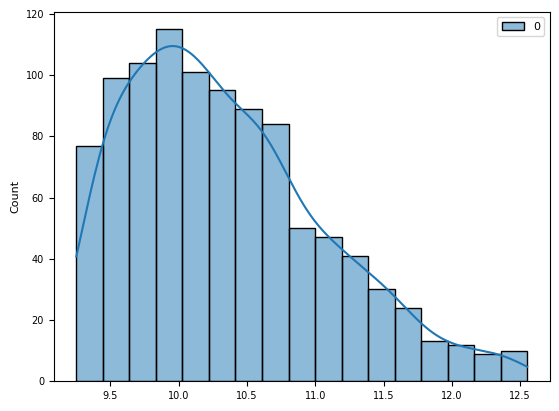

In [91]:
sns.histplot(bin1.cpu().numpy(), kde=True)
#plt.plot(true_fs[0].cpu().numpy())


In [1]:
all_samples = []
for i in range(0, sample_size-1):
    posterior_bin_observed = sel_bin_posteriors2[i][-1].set_default_x(true_fs[i])
    samples = posterior_bin_observed.sample((1000,), method="slice")
    all_samples.append(samples)
    sns.histplot(samples.cpu().numpy(), kde=True)
    plt.savefig('SNRE_Posteriors/bin_sample_{}.png'.format(i)
    )
    plt.close()

print("Finished creating plots")

NameError: name 'sample_size' is not defined